In [1]:
import pandas as pd
import os
import nf_model
import tarfile
from audio_image_pipeline import *
import json
import shutil
import random

#### Unpack compressed data

In [ ]:
# Unpack data
def unpack_jsonwav_archive(archive_path, output_dir):
    """
    Unpack a .jsonwav.tar.gz archive, extracting only .wav and .json files.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    with tarfile.open(archive_path, 'r:gz') as tar:
        members = [m for m in tar.getmembers() if m.name.endswith(('.wav', '.json'))]
        tar.extractall(path=output_dir, members=members)
    print(f"Extracted {len(members)} files from {archive_path} to {output_dir}")
# unpack once after cloning
tar_file = 'nsynth-train.jsonwav.tar.gz'
unpack_jsonwav_archive(
    'data/'+tar_file, # <- Add path to data here
    'data/'
)

Extracted 11 files from data/sample_subset.tar.gz to data/


#### Convert .wav files to spectogram tensors

(10, 128, 126)


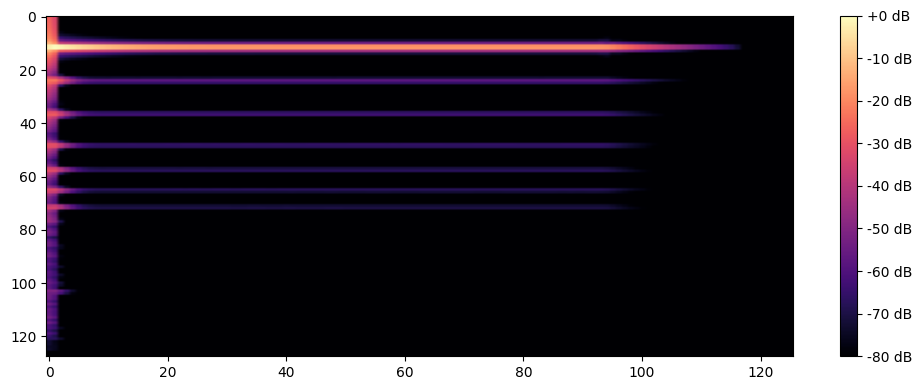

In [19]:
data_path = 'data/sample_subset/' # <-- insert path to data
audio_path = data_path+'audio/' # Path for audio files
spectograms = [] 
for fname in os.listdir(audio_path):
    if not fname.endswith('.wav'):
        continue
    spec_t = audio_to_melspectrogram(
        os.path.join(audio_path, fname),
        sr=16000, n_mels=128, hop_length=512
    )
    spectograms.append(spec_t.numpy())

# stack into array of shape (N, 128, T)
data = np.stack(spectograms, axis=0)
print(data.shape)
plt.figure(figsize=(10,4))
plt.imshow(data[0], aspect='auto', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

#### Convert .json containing labels to dataframe

In [22]:
label_path = "data/nsynth-valid/"
json_path = os.path.join(label_path, "examples.json")

with open(json_path, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()

,keyboard_acoustic_004-060-025,bass_synthetic_033-050-100,bass_synthetic_009-052-050,keyboard_electronic_003-064-127,bass_synthetic_034-030-050,bass_synthetic_098-040-025,bass_synthetic_009-083-075,mallet_acoustic_062-033-075,organ_electronic_113-028-075,keyboard_electronic_098-072-100,...,organ_electronic_007-042-050,keyboard_electronic_078-045-100,keyboard_electronic_003-047-075,vocal_acoustic_000-061-127,guitar_acoustic_014-048-127,bass_electronic_025-051-127,flute_synthetic_000-080-025,vocal_synthetic_003-073-025,bass_synthetic_134-036-100,keyboard_acoustic_004-044-127
note_str,keyboard_acoustic_004-060-025,bass_synthetic_033-050-100,bass_synthetic_009-052-050,keyboard_electronic_003-064-127,bass_synthetic_034-030-050,bass_synthetic_098-040-025,bass_synthetic_009-083-075,mallet_acoustic_062-033-075,organ_electronic_113-028-075,keyboard_electronic_098-072-100,...,organ_electronic_007-042-050,keyboard_electronic_078-045-100,keyboard_electronic_003-047-075,vocal_acoustic_000-061-127,guitar_acoustic_014-048-127,bass_electronic_025-051-127,flute_synthetic_000-080-025,vocal_synthetic_003-073-025,bass_synthetic_134-036-100,keyboard_acoustic_004-044-127
sample_rate,16000,16000,16000,16000,16000,16000,16000,16000,16000,16000,...,16000,16000,16000,16000,16000,16000,16000,16000,16000,16000
qualities_str,"[dark, reverb]",[dark],"[bright, distortion, long_release]",[],"[distortion, tempo-synced]",[dark],"[bright, distortion, long_release]","[dark, multiphonic]",[dark],[],...,"[distortion, long_release, nonlinear_env]",[bright],[],[reverb],[],[],[distortion],"[bright, distortion, long_release, nonlinear_env]","[dark, reverb]",[reverb]
instrument_source,0,2,2,1,2,2,2,0,1,1,...,1,1,1,0,0,1,2,2,2,0
instrument_family_str,keyboard,bass,bass,keyboard,bass,bass,bass,mallet,organ,keyboard,...,organ,keyboard,keyboard,vocal,guitar,bass,flute,vocal,bass,keyboard


## Explaining what each column in the data means


| Index | Qualität    | Beschreibung                        |
|-------|-------------|-----------------------------------|
| 0     | Bright      | Klang ist hell, klar               |
| 1     | Dark        | Klang ist dunkel, dumpf            |
| 2     | Distorted   | Klang ist verzerrt                 |
| 3     | Noisy       | Klang ist verrauscht               |
| 4     | Percussive  | Klang ist perkussiv (schlagzeugartig) |
| 5     | Sustained   | Klang ist gehalten, lang           |
| 6     | Harmonic    | Klang enthält viele Obertöne       |
| 7     | Metallic    | Klang klingt metallisch            |
| 8     | Vocal       | Klang klingt wie Stimme            |
| 9     | Other       | Andere unspezifizierte Eigenschaft |

In [11]:
input_data = nsynth["loudness"].values  # oder eine andere Spalte mit float-Werten
model = NormalizingFlow(input_data)
loss = model.training_step()
print("Loss:", loss)

NameError: name 'nsynth' is not defined

## Script for creating subsets of dataset

In [11]:
# 1) configure
FULL_JSON   = "data/nsynth-valid/examples.json"
AUDIO_DIR   = "data/nsynth-valid/audio"
NUM_SAMPLES = 10                 # <-- number of random files to pick
OUT_DIR     = "data/sample_subset"
OUT_TAR     = "data/sample_subset.tar.gz"

def build_subset(num_samples=NUM_SAMPLES):
    # clean output dir
    if os.path.exists(OUT_DIR):
        shutil.rmtree(OUT_DIR)
    os.makedirs(os.path.join(OUT_DIR, "audio"), exist_ok=True)

    # copy full JSON
    shutil.copy(FULL_JSON, os.path.join(OUT_DIR, "examples.json"))

    # list all wav files & pick random subset
    wav_files = [f for f in os.listdir(AUDIO_DIR) if f.endswith(".wav")]
    if len(wav_files) < num_samples:
        raise ValueError(f"Not enough files in {AUDIO_DIR}")
    selected = random.sample(wav_files, num_samples)

    # copy selected wavs
    for fname in selected:
        src = os.path.join(AUDIO_DIR, fname)
        dst = os.path.join(OUT_DIR, "audio", fname)
        shutil.copy(src, dst)
    print(f"Copied {len(selected)} wavs + JSON → {OUT_DIR}/")

    # tar.gz them up
    with tarfile.open(OUT_TAR, "w:gz") as tar:
        tar.add(OUT_DIR, arcname=os.path.basename(OUT_DIR))
    print(f"Created archive: {OUT_TAR}")

build_subset()

Copied 10 wavs + JSON → data/sample_subset/
Created archive: data/sample_subset.tar.gz
